# Cat and Mouse in a House

In [1]:
from header import *
%matplotlib inline
import matplotlib.pyplot as plt

Nez the mouse is lost in the house below.

<img src="house.png", width=169, height=239 alt="house">

He searches for his hole via simple random walk - he randomly jumps to any of the rooms adjacent to his current room with equal probability. Nez’s hole is in room 8; he will stay here (in safety) if he ever makes it. However, Brodie the cat lives in room 6 - she will eat Nez if he enters her room. Clearly, Nez will eventually be “absorbed”, either into his hole or into Brodie’s belly.
Consider the following scenarios:
1. Nez starts in room 0
2. Nez starts in room 1
3. Nez starts in room 5

For each scenario, answer the folliowing 2 questions.
1. What is the probability that Nez gets eaten? What is the probabilty that Nez gets home safely? (aka - where is he absorbed)
2. How many moves does he make before he gets “absorbed”? (aka - when is he absorbed) Please give the average absorption time AND plot a histogram of the distribution of absorption times (showing what proportion of samples get absorbed after 1 jump, 2 jumps, 3 jumps, etc). Do a search for creating histograms in python - you will likely want to use the matplotlib package.

In [2]:
def architecture_check_passed(transition_matrix, initial_distribution_matrix):
    num_of_states = transition_matrix.shape[0]
    if initial_distribution_matrix.shape[0] != num_of_states:
        #print("Transition matrix and initial distribution dimensions don't match")
        return False

    row_sums  = np.sum(transition_matrix, 1)
    should_be = np.ones_like(row_sums)
    if np.allclose(row_sums, should_be) == False:
        #print('Rows of transition matrix do not all sum to 1')
        return False
    return True

In [3]:
def compute_absorbed_proportions(vector, states_in_recurrent_classes = []):
    if states_in_recurrent_classes == []:
        ap = [1.0]
    else:
        ap = [np.sum(vector[states]) for states in states_in_recurrent_classes]
    return np.array(ap)

In [16]:
def plot_absorption(absorption_proportions, tolerance = 0.001):
    absorption_proportions = np.array(absorption_proportions)
    # total absorbed by all recurrence classes
    absorbed_cumulative = np.sum(absorption_proportions, axis = 1)
    # remove tail, if simulation continued to run after complete absorption
    absorbed_cumulative = absorbed_cumulative[absorbed_cumulative < 1-tolerance]
    # append 1.0 to end
    absorbed_cumulative = np.append(absorbed_cumulative, 1.0)
    # find "newly" absorbed proportion at each step
    absorbed_marginal = np.diff(absorbed_cumulative)
    # np.diff shrinks array by 1 entry so prepend 0.0
    absorbed_marginal = np.insert(absorbed_marginal, 0, absorbed_cumulative[0])
    times = np.arange(absorbed_marginal.shape[0])
    printltx(r"Absorbed proportions (by recurrence class) " + ltxmtx(absorption_proportions[-1]))
    plt.bar(times, absorbed_marginal)
    plt.xlabel('jumps')
    plt.ylabel('proportion')
    plt.title('Distribution of Absorption Times')
    plt.show()
    average = absorbed_marginal.dot(times)
    printltx(r"Mean absorption time is "+str(average))
    return None

In [5]:
def sample_evolution(initial_parameters):
    """
    Evolves the system by simulating many sample paths
    """
    # unpack list
    num_of_steps                = initial_parameters[0]
    num_of_records              = initial_parameters[1]
    num_of_states               = initial_parameters[2]
    num_of_samples              = initial_parameters[3]
    transition_matrix           = initial_parameters[4]
    initial_distribution_matrix = initial_parameters[5]
    states_in_recurrent_classes = initial_parameters[6]
    tolerance                   = initial_parameters[7]
    
    ### -------------- set stage for simulation -------------- ###
    # create empirical probability distribution function
    epdf    = np.zeros([num_of_records, num_of_states], dtype = float)
    # initial the epdf by writing the initial distribution matrix to epdf
    epdf[0] = initial_distribution_matrix[:]
    ap = compute_absorbed_proportions(initial_distribution_matrix, states_in_recurrent_classes)
    absorption_proportions = [ap]
    # There is a nuance here.  For epdf, we only keep the most num_of_records distributions.
    # We really don't need to full prior history, so this help us conserve memory.
    # However we really DO need the full history of absorption_proportions, because
    # we want to plot the full distribution, over ALL time.
    # The problem is that we don't actually know how many steps it will take for complete
    # (or almost complete) absorption. So, we cannot pre-allocate the size of 
    # absorption_propotions (in contrast to epdf, where we can pre-allocate).
    # Therefore, we are stuck "growing the array" (as far as I can tell).
    
    scaled_initial_distribution_matrix = np.rint(initial_distribution_matrix*num_of_samples).astype(int)
    simulation_ledger                  = np.zeros([num_of_records, num_of_samples], dtype = int)

    # initialize simulation ledger by distributing probabilities
    # from the initial distribution matrix to the sample population
    simulation_ledger_index_1 = 0
    for state_index in range(num_of_states):
        simulation_ledger_index_2 = simulation_ledger_index_1 + scaled_initial_distribution_matrix[state_index]
        simulation_ledger[0, simulation_ledger_index_1:simulation_ledger_index_2] = state_index
        simulation_ledger_index_1 = simulation_ledger_index_2
    # shuffle the columns in the first row
    np.random.shuffle(simulation_ledger[0])
    
    ### -------------- run the simulation -------------- ###
    step = 0
    while (step < num_of_steps) or (np.sum(ap) < 1-tolerance):
        # "step" here refers to the location with respect to the number of records
        # since we're looping through the same array
        # Because we are not keeping the entire history, we loop repeatedly through the
        # same array, overwriting old states. We move down the rows of simulation_ledger until we hit
        # the bottom. Then we jump back to the top and overwrite existing arrays.
        # The % operator does modular division and accomplishes the necessary looping.
        current_step = step % num_of_records
        next_step    = (step + 1) % num_of_records
        for sample in range(num_of_samples):
            current_state      = simulation_ledger[current_step, sample]
            # choose random number between 0 and 1
            random_probability = np.random.rand()
            # randomly decide which state sample goes to next
            for next_state in range(num_of_states):
                random_probability -= transition_matrix[current_state, next_state]
                if random_probability < 0:
                    simulation_ledger[next_step, sample] = next_state
                    break
        vector = np.histogram(simulation_ledger[next_step, :], \
                                          normed = True, bins = range(num_of_states + 1))[0]
        epdf[next_step, :] = vector
        ap = compute_absorbed_proportions(vector, states_in_recurrent_classes)
        absorption_proportions.append(ap)
        step += 1
    
    # right now, the last distribution is not necessarily on the bottom of the epdf matrix;
    # so, the following code rearranges the rows of the matrix to make sure the final distribution is on bottom
    epdf = np.roll(epdf, num_of_records - next_step - 1, axis = 0)
    plot_absorption(absorption_proportions, tolerance = tolerance)
    return epdf

In [13]:
def matrix_multiplication_evolution(initial_parameters):
    # unpack list
    num_of_steps                = initial_parameters[0]
    num_of_records              = initial_parameters[1]
    num_of_states               = initial_parameters[2]
    transition_matrix           = initial_parameters[3]
    initial_distribution_matrix = initial_parameters[4]
    
    ### -------------- set stage for simulation -------------- ###
    # create theoretical probability distribution function
    tpdf    = np.zeros([num_of_records, num_of_states], dtype = float)
    # initialize the tpdf by writing the initial distribution matrix to tpdf
    tpdf[0] = initial_distribution_matrix[:]
    ap = compute_absorbed_proportions(initial_distribution_matrix, states_in_recurrent_classes)
    absorption_proportions = [ap]
    printltx(r"initialized tpdf = " + ltxmtx(tpdf))
    
    ### -------------- run the simulation -------------- ###
    step = 0
    while (step < num_of_steps) or (np.sum(ap) < 1-tolerance):
        current_step       = step % num_of_records
        next_step          = (step + 1) % num_of_records
        tpdf[next_step, :] = tpdf[current_step, :].dot(transition_matrix)        
        
        ap = compute_absorbed_proportions(tpdf[next_step,:], states_in_recurrent_classes)
        absorption_proportions.append(ap)
        step += 1
        
    # right now, the last distribution is not necessarily on the bottom of the epdf matrix;
    # so, the following code rearranges the rows of the matrix to make sure the final distribution is on bottom
    tpdf = np.roll(tpdf, num_of_records - next_step - 1, axis = 0)
    plot_absorption(absorption_proportions, tolerance = tolerance)
    return tpdf

In [17]:
def print_conclusions(num_of_steps, num_of_records, num_of_samples, pdf, method):
    if method == 'sample_evolution':
        printltx(r"I did " + str(num_of_steps) + " steps with " + str(num_of_samples) + \
                 " samples. The last " + str(num_of_records) + \
                 " distributions are written as below:")
        display(pdf)
        printltx(r"The average of these distributions, $\vec{\pi}$, is " + ltxmtx(np.mean(pdf, 0)))
        printltx(r"The probability that Nez gets eaten is " + str(np.mean(pdf, 0)[6]))
        printltx(r"The probability that Nez gets home safely is " + str(np.mean(pdf, 0)[8]))
    if method == 'matrix_multiplication_evolution':
        printltx(r"I did " + str(num_of_steps) + " steps. The last " + \
                 str(num_of_records) + " distributions are written as below:")
        display(pdf)
        printltx(r"The average of these distributions, $\vec{\pi}$, is " + ltxmtx(np.mean(pdf, 0)))
        printltx(r"The probability that Nez gets eaten is " + str(np.mean(pdf, 0)[6]))
        printltx(r"The probability that Nez gets home safely is " + str(np.mean(pdf, 0)[8]))
    if method == 'eigen_future':
        return None

Define various initial distributions that represent where the mouse starts in the house.

In [8]:
phi0 = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0])
phi1 = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0])
phi5 = np.array([0, 0, 0, 0, 0, 1, 0, 0, 0])
initial_distributions = [phi0, phi1, phi5]

Define transition matrix that's a 3x3 grid since we have 9 states. This random walk will be a simple one.

In [9]:
P = np.array([[0, .5, 0, .5, 0, 0, 0, 0, 0], [1/3, 0, 1/3, 0, 1/3, 0, 0, 0, 0], [0, .5, 0, 0, 0, .5, 0, 0, 0], \
              [1/3, 0, 0, 0, 1/3, 0, 1/3, 0, 0], [0, 1/4, 0, 1/4, 0, 1/4, 0, 1/4, 0], [0, 0, 1/3, 0, 1/3, 0, 0, 0, 1/3], \
              [0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1/3, 0, 1/3, 0, 1/3], [0, 0, 0, 0, 0, 0, 0, 0, 1]])

Initialize parameters.

In [10]:
num_of_steps                = 1000
num_of_records              = 10
num_of_states               = phi0.shape[0]
num_of_samples              = 2000
states_in_recurrent_classes = [[6], [8]]
tolerance                   = 0.001

## Solution via Sample Evolution

<IPython.core.display.Latex object>

---------------------------------------------------------------------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

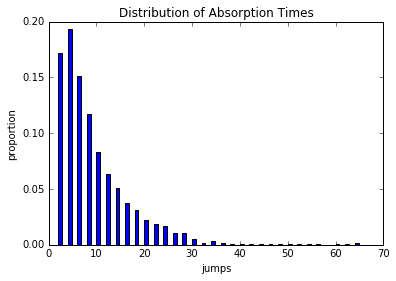

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.6055,
         0.    ,  0.3945],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.6055,
         0.    ,  0.3945],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.6055,
         0.    ,  0.3945],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.6055,
         0.    ,  0.3945],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.6055,
         0.    ,  0.3945],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.6055,
         0.    ,  0.3945],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.6055,
         0.    ,  0.3945],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.6055,
         0.    ,  0.3945],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.6055,
         0.    ,  0.3945],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.6055,
         0.    ,  0.3945]])

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

---------------------------------------------------------------------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

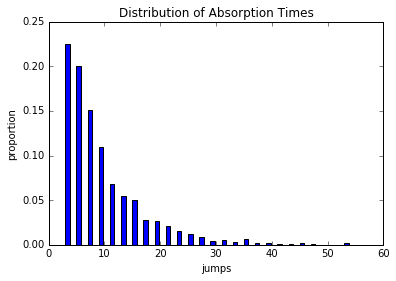

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.4895,
         0.    ,  0.5105],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.4895,
         0.    ,  0.5105],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.4895,
         0.    ,  0.5105],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.4895,
         0.    ,  0.5105],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.4895,
         0.    ,  0.5105],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.4895,
         0.    ,  0.5105],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.4895,
         0.    ,  0.5105],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.4895,
         0.    ,  0.5105],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.4895,
         0.    ,  0.5105],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.4895,
         0.    ,  0.5105]])

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

---------------------------------------------------------------------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

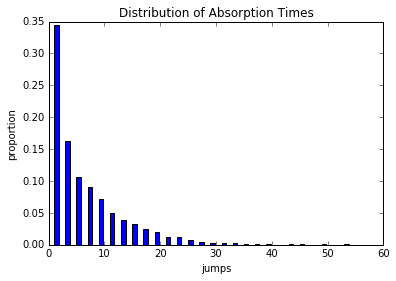

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.2955,
         0.    ,  0.7045],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.2955,
         0.    ,  0.7045],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.2955,
         0.    ,  0.7045],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.2955,
         0.    ,  0.7045],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.2955,
         0.    ,  0.7045],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.2955,
         0.    ,  0.7045],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.2955,
         0.    ,  0.7045],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.2955,
         0.    ,  0.7045],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.2955,
         0.    ,  0.7045],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.2955,
         0.    ,  0.7045]])

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [19]:
printltx(r"Transition matrix $=$" + ltxmtx(P))
if architecture_check_passed:
    for initial_distribution in initial_distributions:
        print(r"---------------------------------------------------------------------------------")
        printltx(r"Initial distribution $=$" + ltxmtx(initial_distribution))
        initial_parameters = [num_of_steps, num_of_records, num_of_states, num_of_samples,
                     P, initial_distribution, states_in_recurrent_classes, tolerance]
        sample_evolution_epdf = sample_evolution(initial_parameters)
        print_conclusions(num_of_steps, num_of_records, num_of_samples, sample_evolution_epdf, 'sample_evolution')

## Solution via Matrix Multiplication

<IPython.core.display.Latex object>

---------------------------------------------------------------------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

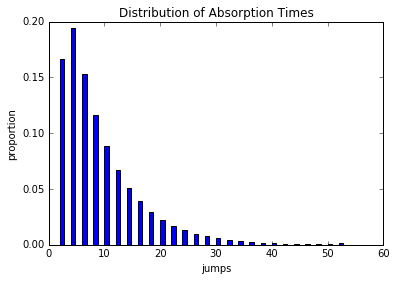

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

array([[  0.00000000e+00,   5.14406159e-60,   0.00000000e+00,
          3.29419636e-60,   0.00000000e+00,   3.29419636e-60,
          6.00000000e-01,   1.44433113e-60,   4.00000000e-01],
       [  2.81275265e-60,   0.00000000e+00,   2.81275265e-60,
          0.00000000e+00,   4.39226182e-60,   0.00000000e+00,
          6.00000000e-01,   0.00000000e+00,   4.00000000e-01],
       [  0.00000000e+00,   3.91081811e-60,   0.00000000e+00,
          2.50444178e-60,   0.00000000e+00,   2.50444178e-60,
          6.00000000e-01,   1.09806545e-60,   4.00000000e-01],
       [  2.13841996e-60,   0.00000000e+00,   2.13841996e-60,
          0.00000000e+00,   3.33925571e-60,   0.00000000e+00,
          6.00000000e-01,   0.00000000e+00,   4.00000000e-01],
       [  0.00000000e+00,   2.97323389e-60,   0.00000000e+00,
          1.90402391e-60,   0.00000000e+00,   1.90402391e-60,
          6.00000000e-01,   8.34813927e-61,   4.00000000e-01],
       [  1.62575260e-60,   0.00000000e+00,   1.62575260e-60,
   

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

---------------------------------------------------------------------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

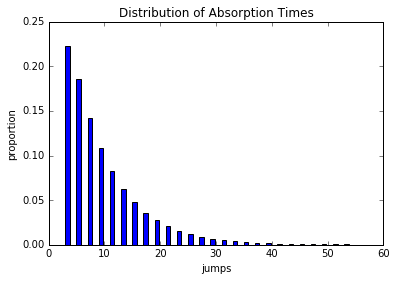

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

array([[  3.42937440e-60,   0.00000000e+00,   3.42937440e-60,
          0.00000000e+00,   5.35514924e-60,   0.00000000e+00,
          5.00000000e-01,   0.00000000e+00,   5.00000000e-01],
       [  0.00000000e+00,   4.76816171e-60,   0.00000000e+00,
          3.05347451e-60,   0.00000000e+00,   3.05347451e-60,
          5.00000000e-01,   1.33878731e-60,   5.00000000e-01],
       [  2.60721207e-60,   0.00000000e+00,   2.60721207e-60,
          0.00000000e+00,   4.07129934e-60,   0.00000000e+00,
          5.00000000e-01,   0.00000000e+00,   5.00000000e-01],
       [  0.00000000e+00,   3.62503691e-60,   0.00000000e+00,
          2.32143087e-60,   0.00000000e+00,   2.32143087e-60,
          5.00000000e-01,   1.01782484e-60,   5.00000000e-01],
       [  1.98215593e-60,   0.00000000e+00,   1.98215593e-60,
          0.00000000e+00,   3.09524116e-60,   0.00000000e+00,
          5.00000000e-01,   0.00000000e+00,   5.00000000e-01],
       [  0.00000000e+00,   2.75596622e-60,   0.00000000e+00,
   

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

---------------------------------------------------------------------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

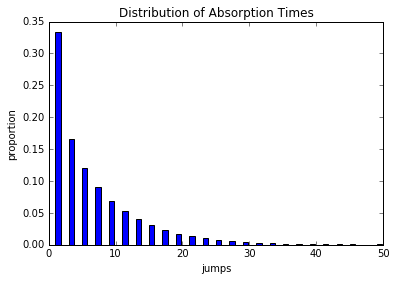

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

array([[  2.19613091e-60,   0.00000000e+00,   2.19613091e-60,
          0.00000000e+00,   3.42937440e-60,   0.00000000e+00,
          3.00000000e-01,   0.00000000e+00,   7.00000000e-01],
       [  0.00000000e+00,   3.05347451e-60,   0.00000000e+00,
          1.95540905e-60,   0.00000000e+00,   1.95540905e-60,
          3.00000000e-01,   8.57343599e-61,   7.00000000e-01],
       [  1.66962785e-60,   0.00000000e+00,   1.66962785e-60,
          0.00000000e+00,   2.60721207e-60,   0.00000000e+00,
          3.00000000e-01,   0.00000000e+00,   7.00000000e-01],
       [  0.00000000e+00,   2.32143087e-60,   0.00000000e+00,
          1.48661694e-60,   0.00000000e+00,   1.48661694e-60,
          3.00000000e-01,   6.51803018e-61,   7.00000000e-01],
       [  1.26934927e-60,   0.00000000e+00,   1.26934927e-60,
          0.00000000e+00,   1.98215593e-60,   0.00000000e+00,
          3.00000000e-01,   0.00000000e+00,   7.00000000e-01],
       [  0.00000000e+00,   1.76488825e-60,   0.00000000e+00,
   

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [22]:
printltx(r"Transition matrix $=$" + ltxmtx(P))
if architecture_check_passed:
    for initial_distribution in initial_distributions:
        print(r"---------------------------------------------------------------------------------")
        printltx(r"Initial distribution $=$" + ltxmtx(initial_distribution))
        initial_parameters = [num_of_steps, num_of_records, num_of_states,
                     P, initial_distribution]
        matrix_multiplication_evolution_tpdf = matrix_multiplication_evolution(initial_parameters)
        print_conclusions(num_of_steps, num_of_records, num_of_samples, matrix_multiplication_evolution_tpdf, 'matrix_multiplication_evolution')

## Conclusions

If Nez starts at room 0, he is slightly more likely, on average, to get eaten.  
If Nez starts at room 1, he is slightly less likely, on average, to get eaten.  
However, is Nez starts at room 5, he is far more likely to make it to his hole and not get eaten.